# Crowdfunding Projects Clustering
#### Author: Kunyu He, CAPP'20, The University of Chicago

In [1]:
import sys
sys.path.append('../codes/')

In [2]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
 
from featureEngineering import FeaturePipeLine, create_dirs
from viz import read_data
from kmeans import KMeansPipeline

In [3]:
INPUT_DIR = "../data/"

## 1. Load Data

In [4]:
project = read_data("projects.csv", drop_na=False)
project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124976 entries, 0 to 124975
Data columns (total 27 columns):
projectid                                 124976 non-null object
teacher_acctid                            124976 non-null object
schoolid                                  124976 non-null object
school_ncesid                             115743 non-null float64
school_latitude                           124976 non-null float64
school_longitude                          124976 non-null float64
school_city                               124976 non-null object
school_state                              124976 non-null object
school_metro                              109752 non-null object
school_district                           124804 non-null object
school_county                             124976 non-null object
school_charter                            124976 non-null object
school_magnet                             124976 non-null object
teacher_prefix                           

## 2. Data Preprocessing

As we are dealing with a clustering task, there's no need to split the data set before preprocessing. First, adjust the configuration of preprocessing pipeline.

In [5]:
FeaturePipeLine.TO_CREATE_CON = {'days_fully_funded': (['datefullyfunded',
                                                        'date_posted'],
                                                       lambda x, y: (x - y + pd.Timedelta(days=1)).dt.days)}

Note that compared to the preprocessing pipeline for the classification task, I dropped `school_city`, `school_state`, `school_district`, and `school_county`.

Note that as I'm no longer predicting whether a project would fail to get fully funded in 60 days, leakage from incorporating both `date_posted` and `datefullyfunded` is no longer of concern. Thus, I further included the year and month of year information for `datefullyfunded` into the processed data. Also, I added a new feature `days_fully_funded` as the number of days the project took to get fully funded.

In [6]:
train_pipe = FeaturePipeLine("Full", project, ask_user=False, test=False)
train_pipe.con_fill_na().str_fill_na().con_create().extract_date().to_binary().feature_target_split()

#----------------------------------------------------------------------------------------------------------------------------------#
<BATCH Full> Creating the preprocessing pipeline for 'projects.csv'.
	Finished reading cleaned data.

<BATCH Full: Training data preprocessing> Pipeline using Standard Scaler.


Start to impute missing values continuous variables:
	Missing values in 'students_reached' imputed with column  median 30.000.


Start to fill in missing values:
	Filled missing values in 'grade_level' with 'Grades PreK-2'.
	Filled missing values in 'school_metro' with 'urban'.
	Filled missing values in 'school_district' with 'MISC'.
	Filled missing values in 'primary_focus_subject' with 'Other'.
	Filled missing values in 'primary_focus_area' with 'Other'.
	Filled missing values in 'secondary_focus_subject' with 'MISC'.
	Filled missing values in 'secondary_focus_area' with 'MISC'.
	Filled missing values in 'resource_type' with 'Technology'.


Start to create new continuous variabl

Preprocess the data and keep enough information to describe each cluster.

In [7]:
project = train_pipe.data.copy(deep=True)
project.head()

,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,school_county,school_charter,school_magnet,teacher_prefix,...,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,days_fully_funded,datefullyfunded_year,datefullyfunded_month,date_posted_year,date_posted_month
0,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,Cook,0.0,0.0,Mrs.,...,highest poverty,Grades PreK-2,1498.61,31.0,0.0,19,2013,5,2013,4
1,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,Ventura,0.0,0.0,Mrs.,...,highest poverty,Grades 3-5,282.47,28.0,1.0,12,2012,4,2012,4
2,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,Los Angeles,0.0,0.0,Ms.,...,high poverty,Grades 3-5,1012.38,56.0,0.0,77,2012,4,2012,1
3,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,Kings (Brooklyn),0.0,1.0,Ms.,...,high poverty,Grades PreK-2,175.33,23.0,0.0,56,2012,12,2012,10
4,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,Suffolk,0.0,0.0,Mrs.,...,high poverty,Grades PreK-2,3591.11,150.0,0.0,77,2013,3,2013,1


Finish the preprocessing.

In [8]:
train_pipe.to_combine().one_hot()
train_pipe.X = train_pipe.data
train_pipe.scale().save_data()



Start to combine unnecessary levels of multinomials.
	Combinations of levels on 'school_city'.
	Combinations of levels on 'school_state'.
	Combinations of levels on 'school_district'.
	Combinations of levels on 'school_county'.
	Combinations of levels on 'primary_focus_subject'.
	Combinations of levels on 'primary_focus_area'.
	Combinations of levels on 'secondary_focus_subject'.
	Combinations of levels on 'secondary_focus_area'.
	Combinations of levels on 'resource_type'.


Finished applying one-hot-encoding to the following categorical variables: ['school_city', 'school_state', 'school_district', 'school_county', 'school_metro', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level']




<Training data preprocessing> Fitted scaler dumped to 'fitted_scaler.pkl' under directory '../data/Batch Full/'.
Finished scaling the feature matrix.


Saved the resulting NumPy matrices to 

Up till now, data is ready for clustering.

In [9]:
X = train_pipe.X

## 3. Projects Clustering

In [10]:
kmeans_pipe = KMeansPipeline(X, project, [5, 10, 50, 100, 200, 300, 500])

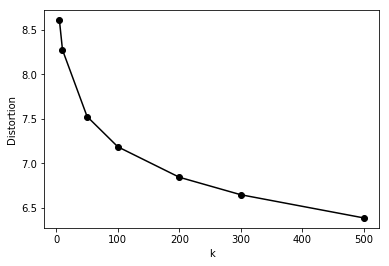

In [11]:
kmeans_pipe.find_best_k()

There's no obvious elbow but 50 seems to be a reasonable number of clusters.

## 4. User Interaction

#### 1. Recluster

User can recluster with a new `k`, say, 75 with the `cluster(k)` method. It returns a KMeans fitted model.

In [12]:
kmeans_75 = kmeans_pipe.cluster(75)
kmeans_75

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=75, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

#### 2. Split a specific cluster into many

To split a specific cluster into many, the user need to apply one KMeans model to the data. Say KMeans model with 50 clusters.

In [13]:
kmeans_pipe.apply_cluster(50)

The `merge_clusters(to_merge)` method implemented the function. Below shows an example of merging clusters 48, 49 to cluster 47.

In [14]:
kmeans_pipe.data.Cluster[kmeans_pipe.data.Cluster.isin([48, 49, 47])].value_counts()

47    3137
49    2462
48    2328
Name: Cluster, dtype: int64

In [15]:
kmeans_pipe.merge_clusters([48, 49], 47)

In [16]:
kmeans_pipe.data.Cluster[kmeans_pipe.data.Cluster.isin([48, 49, 47])].value_counts()

47    7927
Name: Cluster, dtype: int64

#### 3. Split a specific cluster into many

To split a specific cluster, first the user need to apply a certain clustering.

In [17]:
kmeans_pipe.apply_cluster(50)

Then he need to pick a specific cluster to further cluster on.

In [18]:
cluster_47 = kmeans_pipe.data[kmeans_pipe.data.Cluster == 47].copy(deep=True)
cluster_47.shape

(3137, 26)

Apply preprocessing.

In [19]:
cluster_47_pipe = FeaturePipeLine("Cluster 47", cluster_47, ask_user=False, test=False)
cluster_47_pipe.to_combine().one_hot()
cluster_47_pipe.X = cluster_47_pipe.data
cluster_47_pipe.scale()

#----------------------------------------------------------------------------------------------------------------------------------#
<BATCH Cluster 47> Creating the preprocessing pipeline for 'projects.csv'.
	Finished reading cleaned data.

<BATCH Cluster 47: Training data preprocessing> Pipeline using Standard Scaler.


Start to combine unnecessary levels of multinomials.
	Combinations of levels on 'school_city'.
	Combinations of levels on 'school_state'.
	Combinations of levels on 'school_district'.
	Combinations of levels on 'school_county'.
	Combinations of levels on 'primary_focus_subject'.
	Combinations of levels on 'primary_focus_area'.
	Combinations of levels on 'secondary_focus_subject'.
	Combinations of levels on 'secondary_focus_area'.
	Combinations of levels on 'resource_type'.


Finished applying one-hot-encoding to the following categorical variables: ['school_city', 'school_state', 'school_district', 'school_county', 'school_metro', 'teacher_prefix', 'primary_focus_subje

To store KMeans models fitted on a single cluster from previous clustering process, create a new directory.

In [23]:
cluster47_path = './models/full50/cluster47/'
create_dirs('./models/full50/cluster47/')

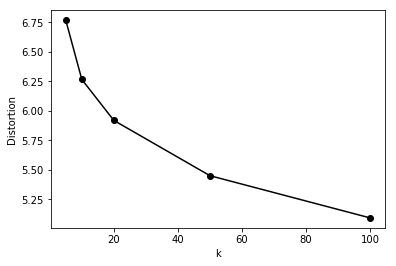

In [27]:
kmeans47 = KMeansPipeline(cluster_47_pipe.X, cluster_47, [5, 10, 20, 50, 100], output_dir=cluster47_path)
kmeans47.find_best_k()

This allows users to split a specific cluster into many.